## UNIFI: A UNIFIED FRAMEWORK FOR PORTFOLIO MANAGEMENT DEMO

### Imports packages

In [38]:
from sys import path
from os.path import dirname as dir
path.append(dir(path[0]))
from statistics import median
from AgentLayer.ConventionalAgents.LRAgent import LRAgent
from AgentLayer.ConventionalAgents.SVRAgent import SVRAgent
from AgentLayer.DataSplitter.TimeSeriesSplitter import TimeSeriesSplitter
from FinancialDataLayer.DataCollection.DataDownloader import DataDownloader
from FinancialDataLayer.DataProcessing.DefaultFeatureEngineer import DefaultFeatureEngineer
from EvaluationLayer.PortfolioEvaluator import PortfolioEvaluator
from AgentLayer.RLAgents.A2C import A2C
from AgentLayer.Environment.PortfolioEnv import PortfolioEnv
import yaml
import numpy as np
from AgentLayer.metrics import *

### Import user parameters

In [39]:
# IMPORT .yaml FILE
# Gather user parameters
with open("..//user_params.yaml", "r") as stream:
    try:
        user_params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

tickers = user_params["TICKERS"]
tech_indicator_list = user_params["FEATURE_ENG_PARAMS"]["tech_indicator_list"]
env_kwargs = user_params["ENV_PARAMS"]
train_params = user_params["TRAIN_PARAMS"]
policy_params = user_params["POLICY_PARAMS"]
test_params = user_params["TEST_PARAMS"]
feature_list = env_kwargs["feature_list"]
train_start = user_params["TRAIN_START_DATE"]
train_end = user_params["TRAIN_END_DATE"]
trade_start = user_params["TRADE_START_DATE"]
trade_end = user_params["TRADE_END_DATE"]

In [40]:
tech_indicator_list

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [41]:
feature_list

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma',
 'close']

In [42]:
train_params["A2C_PARAMS"]

{'total_timesteps': 100000,
 'callback': None,
 'log_interval': 100,
 'eval_env': None,
 'eval_freq': -1,
 'n_eval_episodes': 5,
 'tb_log_name': 'A2C',
 'eval_log_path': None,
 'reset_num_timesteps': True}

In [43]:
env_kwargs

{'hmax': 100,
 'initial_amount': 1000000,
 'transaction_cost_pct': 0.001,
 'state_space': 4,
 'stock_dim': 4,
 'feature_list': ['macd',
  'boll_ub',
  'boll_lb',
  'rsi_30',
  'cci_30',
  'dx_30',
  'close_30_sma',
  'close_60_sma',
  'close'],
 'action_space': 4,
 'reward_scaling': 0.1}

### Download data

In [44]:
# FETCH DATA
downloaded_df = DataDownloader(start_date=train_start,
                                end_date=trade_end,
                                ticker_list=tickers).download_from_yahoo()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (12756, 8)


In [45]:
downloaded_df.head()

,date,open,high,low,close,volume,tic,day
0,2008-12-31,3.070357,3.133571,3.047857,2.606278,607541200,AAPL,2
1,2008-12-31,41.590000,43.049999,41.500000,32.005898,5443100,BA,2
2,2008-12-31,43.700001,45.099998,43.700001,30.628824,6277400,CAT,2
3,2008-12-31,72.900002,74.629997,72.900002,43.314434,9964300,CVX,2
4,2009-01-02,3.067143,3.251429,3.041429,2.771173,746015200,AAPL,4


### Preprocess Data

In [46]:
data_processor = DefaultFeatureEngineer(use_default=False,
                                        tech_indicator_list=tech_indicator_list,
                                        use_vix=False,
                                        use_return=True,
                                        use_turbulence=False,
                                        use_covar=True)
# add technical indicators as features
df_processed = data_processor.extend_data(downloaded_df)

Successfully added technical indicators
Successfully added covariances
Successfully added returns


In [47]:
df_processed.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2010-12-31,AAPL,11.533929,11.552857,11.475357,9.849806,193508000.0,4.0,0.091907,9.973604,9.686130,58.973111,56.041751,4.076954,9.738818,9.566210,"[[0.00028413594477857897, 0.000181404602563177...",tic AAPL BA CAT ...
0,2010-12-31,BA,64.900002,65.290001,64.620003,52.123985,2137400.0,4.0,-0.163485,53.158957,50.459630,49.173990,30.865840,6.670857,51.751254,53.392652,"[[0.00028413594477857897, 0.000181404602563177...",tic AAPL BA CAT ...
0,2010-12-31,CAT,93.830002,93.900002,93.309998,68.765228,2542700.0,4.0,1.742875,70.643163,64.949738,68.265999,72.930050,45.749416,65.923380,62.360930,"[[0.00028413594477857897, 0.000181404602563177...",tic AAPL BA CAT ...
0,2010-12-31,CVX,91.580002,91.800003,91.000000,57.546177,5152900.0,4.0,1.203227,58.549672,53.227386,65.105808,107.259721,53.406336,54.660562,53.596117,"[[0.00028413594477857897, 0.000181404602563177...",tic AAPL BA CAT ...
1,2011-01-03,AAPL,11.630000,11.795000,11.601429,10.063869,445138400.0,0.0,0.101105,10.012176,9.684598,62.862118,142.931329,25.488753,9.760336,9.586746,"[[0.00028496182096079395, 0.000180694510005855...",tic AAPL BA CAT ...


### Train-Test split

In [49]:
# split data to train and test
splitter = TimeSeriesSplitter()
train = splitter.get_split_data(df_processed, train_start, train_end)
trade = splitter.get_split_data(df_processed, trade_start, trade_end)

In [50]:
#Prepare data for machine learning models
x_train, y_train = data_processor.prepare_ml_data(train, feature_list)

## Conventional Model (SVM)

### Agent initialization

In [51]:
# Create Linear Regression model and train it
svr = SVRAgent(**policy_params["SVR_PARAMS"])

### Agent training

In [52]:
svr.train_model(x_train, y_train, **train_params["SVR_PARAMS"])

Model trained succesfully


### Agent prediction

In [53]:
SVR_portfolio_df, SVR_meta_coefficient = svr.predict(trade, **test_params["SVR_PARAMS"])

In [54]:
SVR_portfolio_df

,date,account_value
0,2020-07-01,1000000
1,2020-07-02,1002717.337037
2,2020-07-06,1042091.814716
3,2020-07-07,992014.183768
4,2020-07-08,998669.002421
...,...,...
290,2021-08-25,1365591.974686
291,2021-08-26,1358044.117188
292,2021-08-27,1367801.11403
293,2021-08-30,1409405.654901


In [55]:
SVR_meta_coefficient

,AAPL,BA,CAT,CVX
date,,,,
2020-07-01,3.469447e-17,1.000000e+00,0.000000e+00,7.279765e-17
2020-07-02,8.180032e-17,1.000000e+00,0.000000e+00,0.000000e+00
2020-07-06,0.000000e+00,1.000000e+00,0.000000e+00,4.529124e-17
2020-07-07,1.415861e-17,1.000000e+00,1.110223e-16,4.935557e-17
2020-07-08,0.000000e+00,1.000000e+00,2.220446e-16,1.277815e-17
...,...,...,...,...
2021-08-24,1.000000e+00,0.000000e+00,1.006140e-15,0.000000e+00
2021-08-25,1.000000e+00,1.110223e-16,0.000000e+00,5.551115e-17
2021-08-26,1.000000e+00,0.000000e+00,1.812786e-16,0.000000e+00


## Reinforcement Learning Agent (A2C)

### Environment creation 

In [56]:
# CREATE TRAIN ENV
env = PortfolioEnv(df=train, **env_kwargs)
env_train, _ = env.get_env()
# CREATE TEST ENV
env_test = PortfolioEnv(df=trade, **env_kwargs)

In [57]:
# CREATE A2C AGENT
a2c = A2C(env=env_train, **policy_params["A2C_PARAMS"])

### Agent training 

In [58]:
# TRAIN A2C AGENT
a2c.train_model(**train_params["A2C_PARAMS"])

begin_total_asset:1000000
end_total_asset:1383043.578663742
Sharpe:  0.6669748359503836
begin_total_asset:1000000
end_total_asset:955064.9299122704
Sharpe:  0.5026611701074113
begin_total_asset:1000000
end_total_asset:1688392.1700598034
Sharpe:  0.7254121817908138
begin_total_asset:1000000
end_total_asset:1337878.952148246
Sharpe:  0.6173327234658644
begin_total_asset:1000000
end_total_asset:1759480.3400017035
Sharpe:  0.7322923529927283
begin_total_asset:1000000
end_total_asset:1924772.2822903849
Sharpe:  0.7440701887218465
begin_total_asset:1000000
end_total_asset:1604022.2682151487
Sharpe:  0.6641843546288477
begin_total_asset:1000000
end_total_asset:1611039.237407356
Sharpe:  0.6527073799808534
begin_total_asset:1000000
end_total_asset:2194830.7551850565
Sharpe:  0.6141326626892551
begin_total_asset:1000000
end_total_asset:2184782.4367584945
Sharpe:  0.6705157361336763
begin_total_asset:1000000
end_total_asset:2012251.1250627153
Sharpe:  0.6507552536085122
begin_total_asset:1000000

### Agent prediction

In [60]:
# TEST A2C AGENT
A2C_portfolio_df, df_actions_a2c = a2c.predict(environment=env_test, **test_params["A2C_PARAMS"])

begin_total_asset:1000000
end_total_asset:1521648.0575393338
Sharpe:  1.6969905302296733
hit end!


In [61]:
A2C_portfolio_df

,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.004089e+06
2,2020-07-06,1.027394e+06
3,2020-07-07,1.008121e+06
4,2020-07-08,1.021519e+06
...,...,...
290,2021-08-25,1.525147e+06
291,2021-08-26,1.507172e+06
292,2021-08-27,1.525423e+06
293,2021-08-30,1.538191e+06


In [62]:
df_actions_a2c

,AAPL,BA,CAT,CVX
date,,,,
2020-07-01,0.250000,0.250000,0.250000,0.250000
2020-07-02,0.453611,0.212641,0.166874,0.166874
2020-07-06,0.453611,0.212641,0.166874,0.166874
2020-07-07,0.453611,0.212641,0.166874,0.166874
2020-07-08,0.453722,0.212449,0.166915,0.166915
...,...,...,...,...
2021-08-25,0.453611,0.212641,0.166874,0.166874
2021-08-26,0.453611,0.212641,0.166874,0.166874
2021-08-27,0.453611,0.212641,0.166874,0.166874


## Evaluation

In [63]:
evaluator = PortfolioEvaluator(SVR_portfolio_df, A2C_portfolio_df, agent_names=["SVR", "A2C"], baseline_ticker = "^DJI")

### Financial statistics

In [64]:
evaluator.backtest_stats()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (297, 8)


,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
SVR,0.330986,0.397532,0.335378,1.022583,1.230121,0.783898,-0.269068,1.190164,1.545434,NaN,NaN,0.986586,-0.040893
A2C,0.438156,0.530148,0.230180,1.699897,3.081082,0.878358,-0.142209,1.322101,2.551698,NaN,NaN,1.165239,-0.027447
^DJI,0.304585,0.368020,0.140354,1.971819,3.410508,0.950429,-0.089308,1.389677,2.937435,NaN,NaN,1.095174,-0.016585


### Visualization

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (297, 8)


Start date,2020-07-01
End date,2021-08-31
Total months,14
,Backtest
Annual return,33.099%
Cumulative returns,39.753%
Annual volatility,33.538%
Sharpe ratio,1.02
Calmar ratio,1.23
Stability,0.78
Max drawdown,-26.907%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.91,2020-07-15,2020-10-28,2021-03-09,170
1,12.47,2021-03-12,2021-03-23,2021-04-09,21
2,10.47,2021-04-13,2021-05-19,2021-06-28,55
3,7.79,2020-07-06,2020-07-09,2020-07-15,8
4,7.42,2021-07-12,2021-07-19,NaT,NaN


Stress Events,mean,min,max
New Normal,0.14%,-7.43%,8.12%


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (297, 8)


Start date,2020-07-01
End date,2021-08-31
Total months,14
,Backtest
Annual return,43.816%
Cumulative returns,53.015%
Annual volatility,23.018%
Sharpe ratio,1.70
Calmar ratio,3.08
Stability,0.88
Max drawdown,-14.221%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.22,2020-09-01,2020-09-24,2020-11-13,54
1,5.92,2021-01-25,2021-01-29,2021-02-16,17
2,5.89,2021-07-09,2021-07-19,2021-08-11,24
3,5.42,2021-04-15,2021-05-12,2021-07-02,57
4,5.34,2021-08-12,2021-08-19,NaT,NaN


Stress Events,mean,min,max
New Normal,0.16%,-4.85%,4.82%


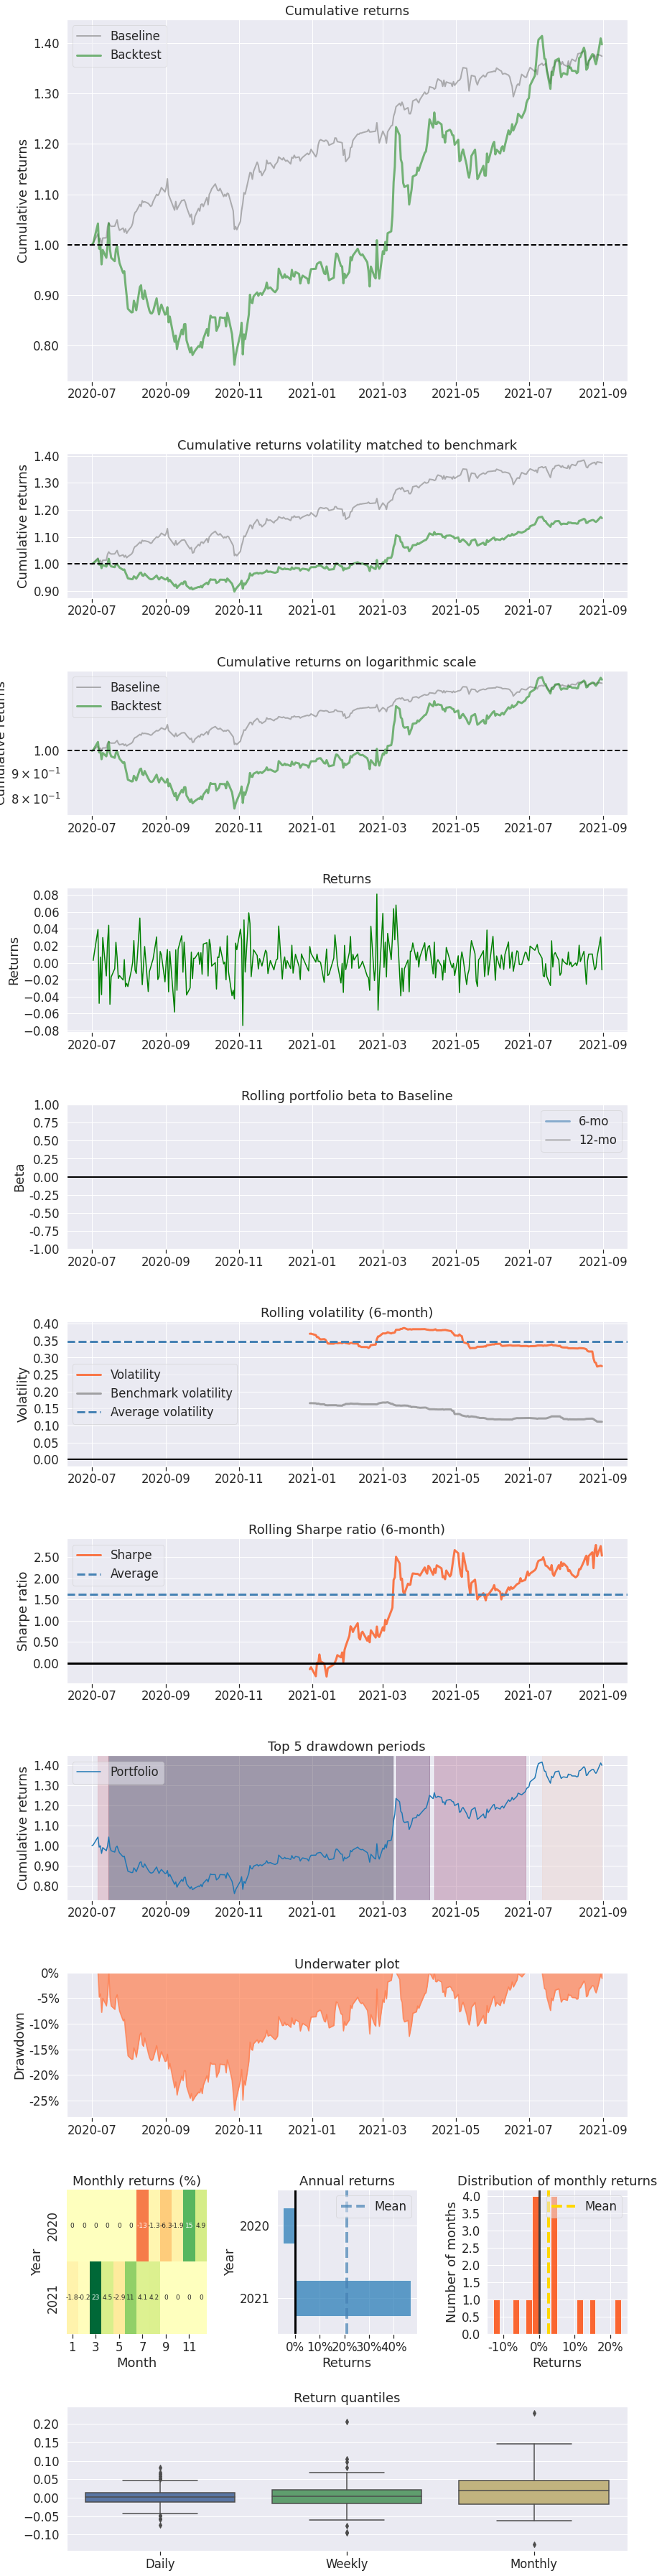

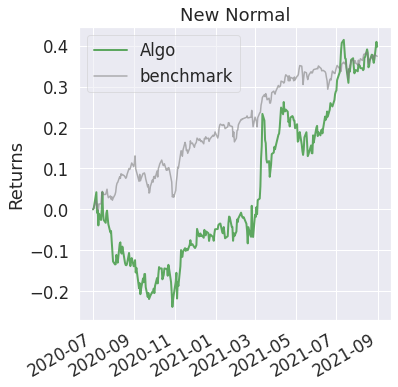

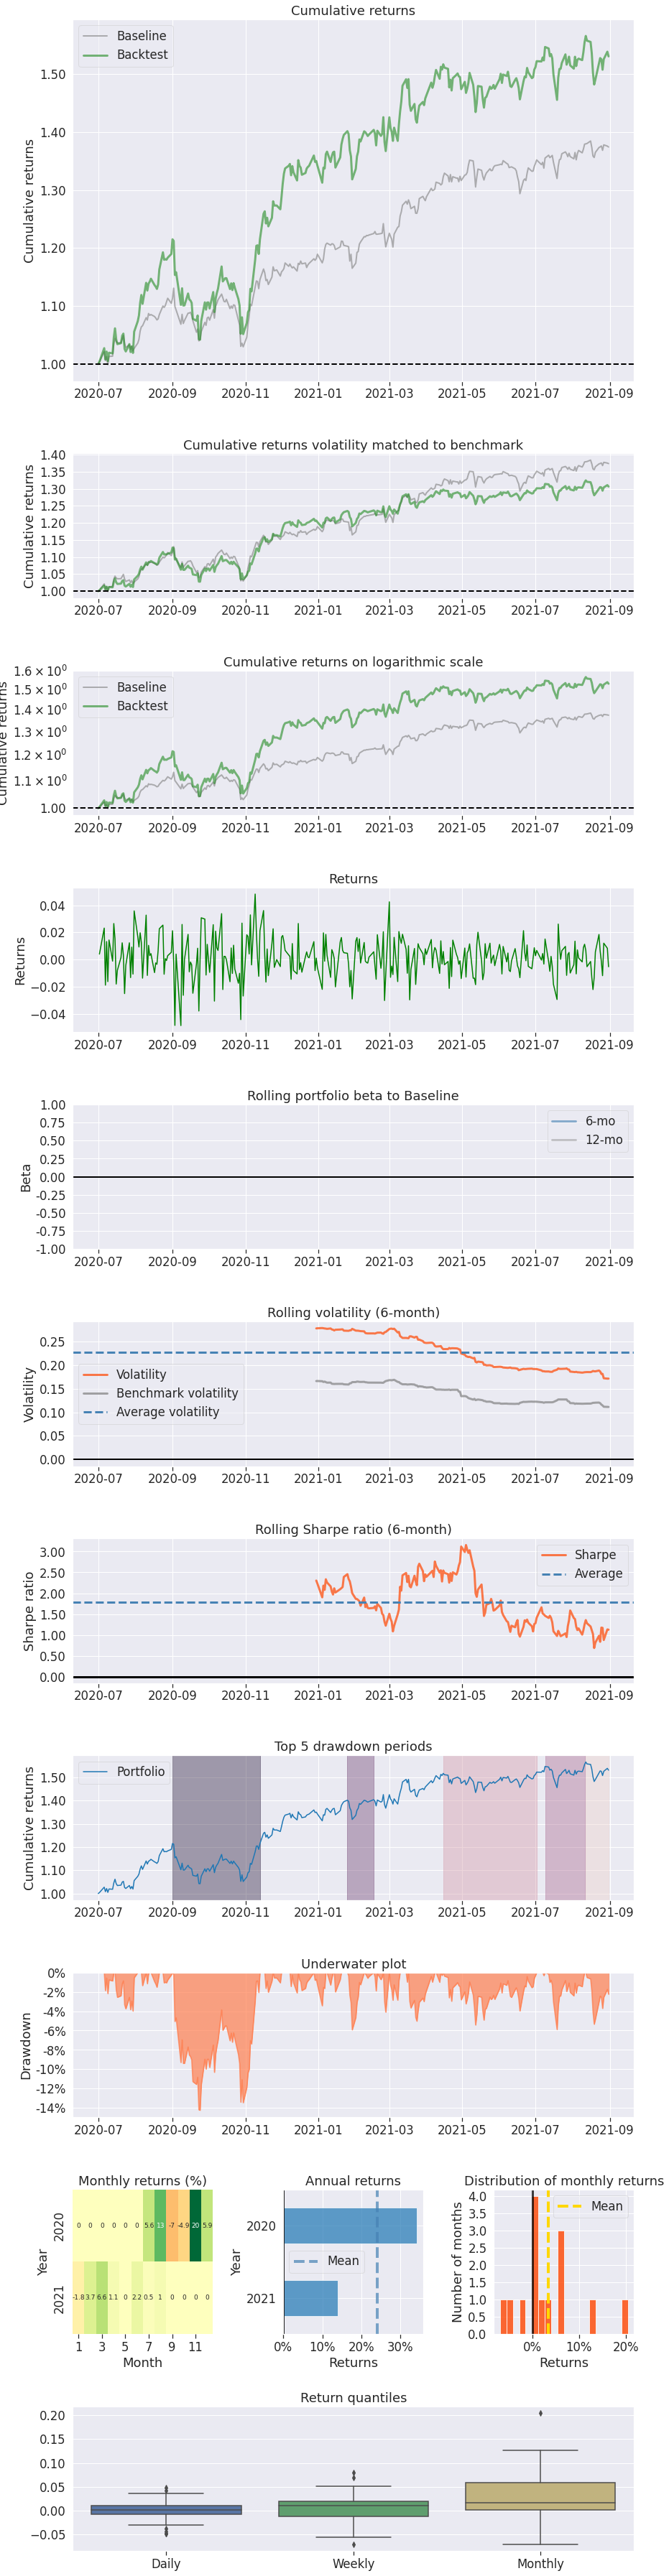

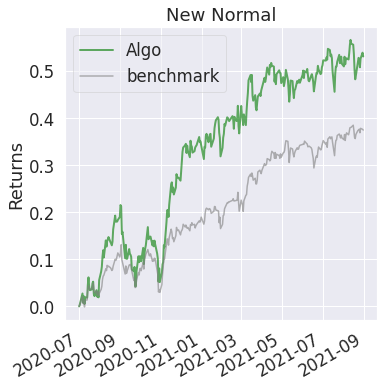

In [65]:
evaluator.backtest_plot()

### Model saving

In [ ]:
#Save model
svr.save_model("svr_model")

In [ ]:
#Load model
my_model = svr.load_model("svr_model")